# Групповой анализ данных (скриптовая версия)

*Особенности:*
- Последовательное выполнение этапов анализа
- Информативные комментарии
- Возможности расширения

In [1]:
%pylab inline
import pandas

Populating the interactive namespace from numpy and matplotlib


## Загрузка данных

Посмотрим данные испытуемого по имени Эмилия http://balatte.stireac.com/result/emiliyamukina@yandex.ru

In [2]:
from IPython.display import IFrame
IFrame('http://balatte.stireac.com/result/emiliyamukina%40yandex.ru/UP6__4145445840150916', width=960, height=480)

Это более продолжительный вариант теста - около 15 мин, вместо 4 мин как при коротком тесте.

In [3]:
D=pandas.read_table('http://balatte.stireac.com/result.tsv/emiliyamukina%40yandex.ru/UP6__4145445840150916')
D.head()

,t,v
0,9.568,0.331
1,17.112,0.290
2,26.284,0.271
3,34.185,0.529
4,43.602,0.248


## Исходные данные

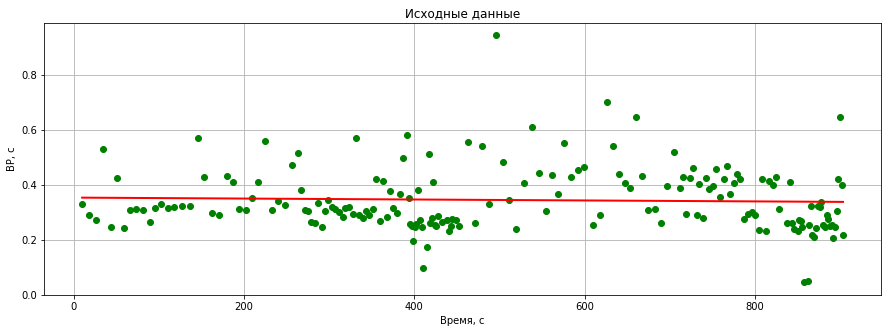

In [20]:
figsize(15,5);
plot(D.t, D.v, 'go')
grid()

Dg=D[isfinite(D.v)]
xx=Dg.t.iloc[[0,-1]]
yy=polyval(polyfit(Dg.t,Dg.v,1), xx)
plot(xx,yy,'r',lw=2);

xlabel('Время, с')
ylabel('ВР, с')
title('Исходные данные');

## Разделение на группы

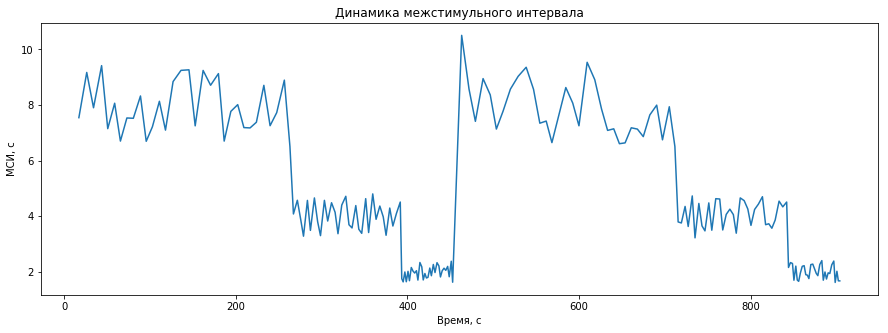

In [21]:
isi=diff(D.t)
plot(D.t[1:], isi)
xlabel('Время, с')
ylabel('МСИ, с')
title('Динамика межстимульного интервала');

Имея в распоряжении ряд значений и соответствующих им МСИ, разделим значения на шесть групп, определяя границы групп по появлению первого МСИ меньше или больше заданного порога (3 или 5 с). Позицию элементов ряда, для которых сравнение с порогом истинно, находим с помощью функции find (англ. найти). Из найденных позиций нам нужна только первая, которая имеет нулевой индекс.

In [6]:
vv=D.v
gg=[]  # пустой массив куда будем складывать группы значений


iab=1                  # начнем с первого
iad=find(isi < 5)[0]   # найдем первую (индекс=0) позицию, где МСИ < 5 с
gg.append(vv[iab:iad]) # добавим выделенный нами фрагмент значений в качестве первой группы

iab=iad                          # следующая группа начинается от той позиции, где закончилась предыдущая
iad=iab+find(isi[iab:] < 3)[0]   # ищем следующее изменение МСИ от текущей позиции, найденную позицию складываем с текущей
gg.append(vv[iab:iad])           # добавим еще один фрагмент значений в качестве следующей группы

iab=iad
iad=iab+find(isi[iab:] > 5)[0]
gg.append(vv[iab:iad])

iab=iad+1             # пропустим реакцию на первый слуховой стимул
iad=iab+find(isi[iab:] < 5)[0]
gg.append(vv[iab:iad])

iab=iad
iad=iab+find(isi[iab:] < 3)[0]
gg.append(vv[iab:iad])

iab=iad
iad=len(vv)                # позиция окончания последней группы соответствует общему размеру массива (искать ничего не надо)
gg.append(vv[iab:iad])


N=list(map(len, gg))
N

[31, 32, 31, 32, 32, 32]

In [7]:
gg = [gg[i].dropna() for i in range(len(gg))]

In [8]:
for i in range(len(gg)):
    gg[i] = gg[i].dropna()

Получили 6 групп по 31-32 значения

## Групповая статистика


In [9]:
M=list(map(mean, gg))
S=list(map(std, gg))
ISI=[8,4,2]
M=array(M).reshape(2,3)
S=array(S).reshape(2,3)
N=array(N).reshape(2,3)
M

array([[ 0.35303226,  0.33465625,  0.28568   ],
       [ 0.4391875 ,  0.36729032,  0.27583333]])

In [10]:
from scipy import stats
xx=arange(3)
pp=[stats.ttest_ind_from_stats(M[0,i],S[0,i],N[0,i], M[1,i],S[1,i],N[1,i]).pvalue for i in xx]
# pp=[stats.ttest_ind(gg[i],gg[i+3])[1] for i in xx]
pp

[0.0061460575727913446, 0.076510863656145484, 0.70068175360316709]

In [11]:
pp=[]
for i in [0,1,2]:
    pp.append(stats.ttest_ind(gg[i],gg[i+3], nan_policy='omit').pvalue)
pp

[0.0069564798035608704, 0.083836302976700985, 0.72636853748586394]

In [12]:
pp=[stats.ttest_ind(gg[i],gg[i+3], equal_var=False)[1] for i in [0,1,2]]
pp

[0.0069391748974923012, 0.083555184028613047, 0.72461238711512399]

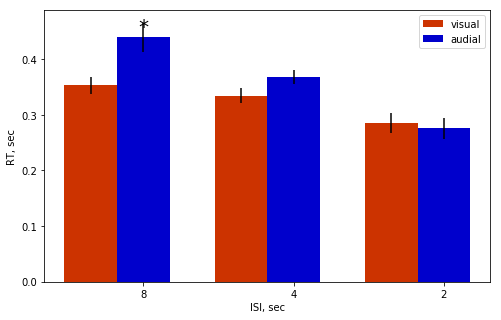

In [13]:
figsize(8,5)

SEM=S/sqrt(N)
width = 0.35 #ширина столбцов
p1 = bar(xx-width, M[0], width, color=(.8,.2,0), yerr=SEM[0])
p2 = bar(xx, M[1], width, color=(0,0,0.8), yerr=SEM[1])
xticks(xx,ISI)
xlabel('ISI, sec')
ylabel('RT, sec')
legend(('visual','audial'))

for i,p in enumerate(pp):
    if p<0.05:
        text(xx[i], max(M[:,i])+0.01, '*', size=20, horizontalalignment='center')

# Дальнейший анализ...
## Модели изменения ВР от МСИ (отдельно для каждой модальности)

In [14]:
#находим границу между зрительными и слуховыми
isi=diff(D.t)
iBr=find(isi>10)[0]+1
iBr

96

In [15]:
# интегрируем расчетные данные как дополнительные показатели
D['isi']=hstack([NaN,isi])
D['log2isi']=log2(D.isi)
D.head()

,t,v,isi,log2isi
0,9.568,0.331,NaN,NaN
1,17.112,0.290,7.544,2.915330
2,26.284,0.271,9.172,3.197236
3,34.185,0.529,7.901,2.982035
4,43.602,0.248,9.417,3.235268


In [16]:
(D.index<iBr).shape

(192,)

In [17]:
bb=isfinite(D.v)
bbV=bb & (D.index<iBr) & (D.index>0)
bbA=bb & (D.index>iBr)

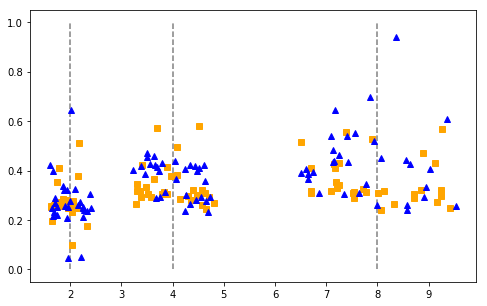

In [24]:
figsize(8,5)
plot(D[bbV].isi, D[bbV].v, 's',color='orange',);
plot(D[bbA].isi, D[bbA].v, 'b^');
vlines(ISI, 0, 1, color='gray',linestyles='dashed');
#xscale('log');

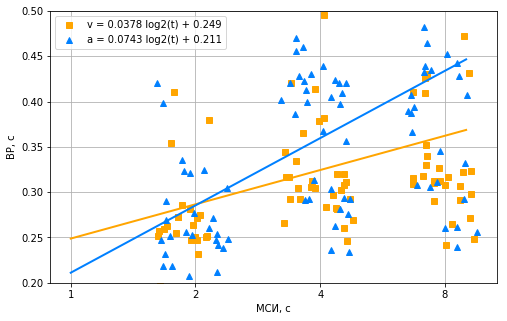

In [25]:
for mod in ['v','a']:
    color=mod=='v' and 'orange' or [0,.5,1]
    marker=mod=='v' and 's' or '^'
    bb=eval('bb'+mod.upper())
    D1=D[bb]
    
    xx=log2(arange(1,10))
    p=polyfit(D1.log2isi, D1.v,1)
    yy=polyval(p,xx)

    s='{} = {:.4f} log2(t) + {:.3f}'.format(mod, p[0],p[1])
    plot(D1.log2isi, D1.v, lw=0, color=color, marker=marker, label=s)
    plot(xx,yy,color=color,lw=2);


vv=2**arange(4)
xticks(log2(vv), vv)
grid(True)
legend();
ylim([.2,.5])
xlabel('МСИ, с');
ylabel('ВР, с');

Мы получили картинки подобные тем, что показываются в приложении на страничке к каждому тесту.

Небольшие различия в значениях коэффициентов объясняются различием в приемах отбраковки выбросов.